In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

%matplotlib inline

/home/mohsin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
training_data = pd.read_csv("../datasets/fashion-mnist/training_data.csv",header=None)
training_data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test_data = pd.read_csv("../datasets/fashion-mnist/test_data.csv",header=None)
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,2,3,0,3,174,189,67,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,164,58,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6,0,0,0,2,0,1,1,0,0,...,71,12,0,0,0,0,0,0,0,0


### Defining the auto-encoder

In [4]:
autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(784,)),
    tf.keras.layers.Dense(128,  activation='elu'),
    tf.keras.layers.Dense(10,    activation='linear', name="bottleneck"),
    tf.keras.layers.Dense(128,  activation='elu'),
    tf.keras.layers.Dense(512,  activation='elu'),
    tf.keras.layers.Dense(784,  activation='sigmoid')
])
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Preparing the dataset.

In [5]:
x_train = training_data.loc[:,1:].values
x_train = x_train / 255.0 # scaling

x_test = test_data.loc[:,1:].values
x_test = x_test / 255.0

In [6]:
trained_model = autoencoder.fit(x_train, x_train, batch_size=32, epochs=32, verbose=1, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/32
60000/60000 [==============================] - 9s 158us/sample - loss: 0.0199 - val_loss: 0.0158
Epoch 2/32
60000/60000 [==============================] - 21s 342us/sample - loss: 0.0150 - val_loss: 0.0145
Epoch 3/32
60000/60000 [==============================] - 11s 176us/sample - loss: 0.0140 - val_loss: 0.0138
Epoch 4/32
60000/60000 [==============================] - 9s 157us/sample - loss: 0.0135 - val_loss: 0.0137
Epoch 5/32
60000/60000 [==============================] - 10s 166us/sample - loss: 0.0132 - val_loss: 0.0133
Epoch 6/32
60000/60000 [==============================] - 9s 146us/sample - loss: 0.0129 - val_loss: 0.0130
Epoch 7/32
60000/60000 [==============================] - 9s 144us/sample - loss: 0.0127 - val_loss: 0.0128
Epoch 8/32
60000/60000 [==============================] - 9s 144us/sample - loss: 0.0125 - val_loss: 0.0127
Epoch 9/32
60000/60000 [==============================] - 9s 153us/sample - loss: 0

In [7]:
encoder = tf.keras.Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

## Generating the gensim index

### Preparing data for gensim indices

In [8]:
training_encodings = encoder.predict(x_train)
test_encodings = encoder.predict(x_test)

In [9]:
indices = []
for item in training_encodings:
    indices.append([(x,y) for (x,y) in enumerate(list(item))])
    
for item in test_encodings:
    indices.append([(x,y) for (x,y) in enumerate(list(item))])

### Generating index

In [10]:
index = gensim.similarities.Similarity("index",indices,10)

## Testing

In [21]:
index.num_best = 25
predict_item = 7 #3 #863
index[encoder.predict(x_train[predict_item].reshape(1,-1)).ravel()][:3]

[(7, 1.0), (36476, 0.9796999096870422), (65530, 0.9711573719978333)]

In [22]:
df = pd.concat([training_data,test_data])
df.index = [x for x in range(len(df))]

In [23]:
similar_classes = dict()
similar_classes['Label'] = []
similar_classes['Features'] = []
for i in [x[0] for x in index[encoder.predict(x_train[predict_item].reshape(1,-1)).ravel()]]:
    similar_classes['Label'].append(df.loc[i,0])
    similar_classes['Features'].append(df.loc[i,1:].values.reshape(28,28))

In [24]:
def plot_images(data_dictionary):
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.title('Class = '+str(data_dictionary['Label'][i]))
        plt.imshow(data_dictionary['Features'][i])

Original Class is 2


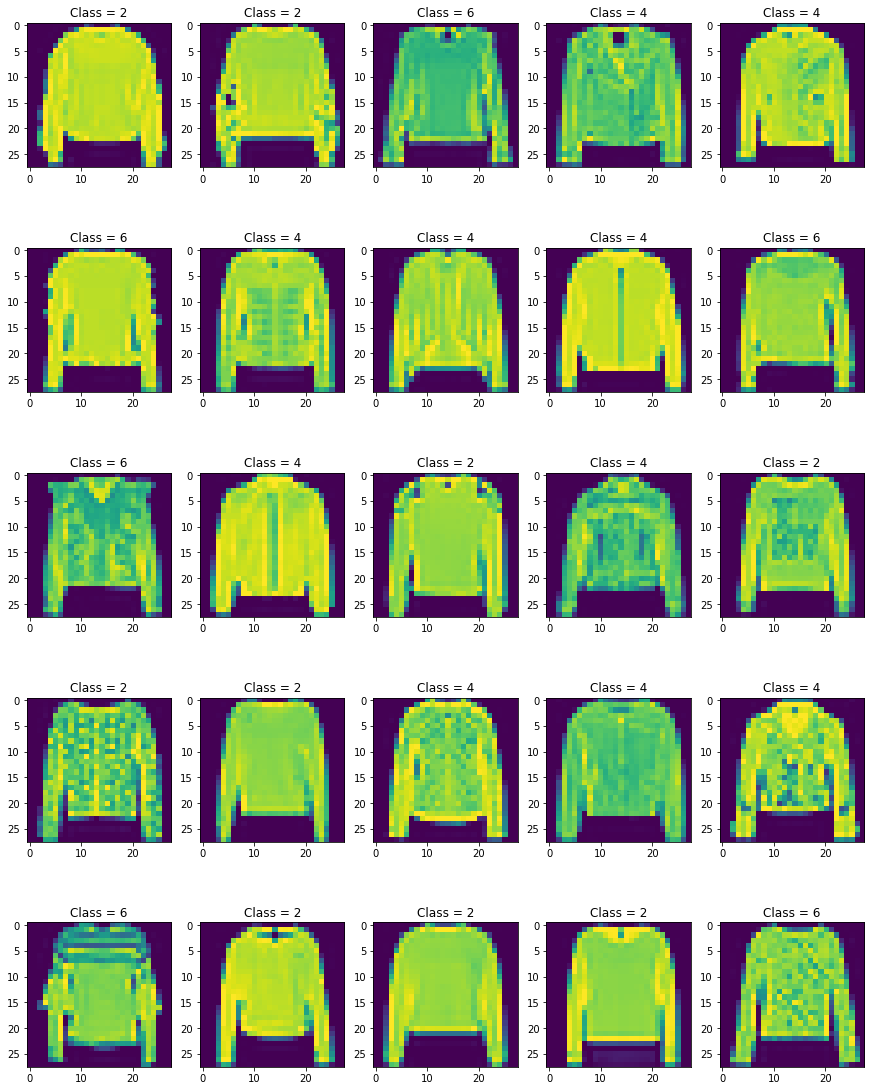

In [25]:
print (f"Original Class is {df.loc[predict_item,0]}")
plt.figure(figsize=(15,20))
plot_images(similar_classes)
plt.show()

### Comments
It has confused class 2 with class 4 and 6 which are pretty much similar to class 2. Our task is to find the visually similar objects and not by the classes hence its pretty good model

The results may improve by changing the similarity measure, currently we are using the cosine similarity. Also we can increase the embedding size from 10 to 15 or something higher which will further improve the results.